In [1]:
import pandas as pd
import numpy as np
import time
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [2]:
# Viewing settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Filters
DC_filter = ['cummings']
MC_filter = ['matthancock', 'matt hancock']

In [4]:
def filter_data(data, filters = DC_filter):
    #Function to filter the weekly data to UK tweets only
    
    #First filter by language to english only
    data = data.loc[data['lang'].str.contains('en', na=False)]
    print("there are ", len(data), "english tweets")
    
    #Next filter by dominic cummings/matt hancock related tweets using the keywords list
    data = data.loc[data['text'].str.contains('|'.join(filters), na=False)]
    
    #Reset index
    data.reset_index(drop=True, inplace=True)
    
    return data

# Now performing the actual filtering, language filtered by english and user.location based on a list of cities/country names defined from UK Cities List

## Loading the data

In [5]:
this_data = pd.read_pickle('/Users/brandon/Documents/UCL/Project/COVID Project/Data/DC_Data_Week_1')
this_data.head(5)

,created_at,text,user.location,lang
0,2020-05-26 12:24:52+00:00,#BycottBJP \n\nBJP virus caused more destruction/damage then Corona virus.,"New Delhi, India 🇮🇳🇮🇳",en
1,2020-05-26 12:24:52+00:00,RT @beatrizbecerrab: Et voilà. \nEmpresas españolas como @IBEROSTAR ya publicitan la inminente apertura de sus hoteles en #Portugal con el s…,NaN,es
2,2020-05-26 12:24:52+00:00,RT @SPAregions: فيروس #كورونا المستجد\n#الصين: ارتفاع الوفيات إلى 4634 من بين 82992 إصابة، بتسجيل 7 حالات لمسافرين.\n#الهند: ارتفاع الوفيات إ…,خميس مشيط,ar
3,2020-05-26 12:24:52+00:00,RT @mrtonyscott: So disappointed @AmericanAir and having anxiety over how my health was put at risk. The person next to me refused to wear…,NaN,en
4,2020-05-26 12:24:52+00:00,RT @AP_Europe: Montenegro has declared itself free of the coronavirus and plans to reopen its borders to citizens of several European count…,"Maiduguri, Nigeria",en


In [6]:
print(len(this_data))

19839968


## Filtering the data

In [7]:
this_data = filter_data(this_data)
this_data.head(5)

there are  13063178 english tweets


,created_at,text,user.location,lang
0,2020-05-26 12:24:57+00:00,RT @vicderbyshire: This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇,NaN,en
1,2020-05-26 12:25:04+00:00,RT @vicderbyshire: This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇 https://t.co/TNT56…,"Durham, England",en
2,2020-05-26 12:27:12+00:00,RT @thicktank: @brisers @iammarkhayward @jwiechers @waybackmachine @MarkGraham @matthew_weaver \nthread showing not only that cummings didn'…,UK,en
3,2020-05-26 12:28:32+00:00,UK minister quits Johnson's government over Cummings lockdown trip #coronavirus #cummings #government #johnsons… https://t.co/2q5HUVjUP1,NaN,en
4,2020-05-26 12:28:48+00:00,@BorisJohnson\n@MattHancock\n@michaelgove\n#cummingsmustgo\nCan you spot the difference? \nhttps://t.co/v3nyffFel6,"England, United Kingdom",en


In [8]:
print(len(this_data))

3430


## Clean Tweets for Sentiment Analysis

In [9]:
def remove_pattern(input_txt, pattern):
    """Function to help remove tweet specific patterns"""
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [10]:
def clean_tweets(tweets):
    """Function to clean tweets specifically as they contain certain patterns and formats different to a normal sentence"""
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [11]:
#Cleaning the tweets
this_data['clean_tweet'] = clean_tweets(this_data['text'])
this_data.head(10)

,created_at,text,user.location,lang,clean_tweet
0,2020-05-26 12:24:57+00:00,RT @vicderbyshire: This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇,NaN,en,This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇
1,2020-05-26 12:25:04+00:00,RT @vicderbyshire: This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇 https://t.co/TNT56…,"Durham, England",en,This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇 …
2,2020-05-26 12:27:12+00:00,RT @thicktank: @brisers @iammarkhayward @jwiechers @waybackmachine @MarkGraham @matthew_weaver \nthread showing not only that cummings didn'…,UK,en,\nthread showing not only that cummings didn'…
3,2020-05-26 12:28:32+00:00,UK minister quits Johnson's government over Cummings lockdown trip #coronavirus #cummings #government #johnsons… https://t.co/2q5HUVjUP1,NaN,en,UK minister quits Johnson's government over Cummings lockdown trip #coronavirus #cummings #government #johnsons…
4,2020-05-26 12:28:48+00:00,@BorisJohnson\n@MattHancock\n@michaelgove\n#cummingsmustgo\nCan you spot the difference? \nhttps://t.co/v3nyffFel6,"England, United Kingdom",en,\n\n\n#cummingsmustgo\nCan you spot the difference? \n
5,2020-05-26 12:32:24+00:00,So #liarcummings edited his blog on his return from Durham! He said he’d predicted this pandemic 🤨🧐,Sheffield UK,en,So #liarcummings edited his blog on his return from Durham! He said he’d predicted this pandemic 🤨🧐
6,2020-05-26 12:33:39+00:00,if there’s a new wave of covid cases after this we have to call it the second cummings,"Exeter, England",en,if there’s a new wave of covid cases after this we have to call it the second cummings
7,2020-05-26 12:33:48+00:00,RT @Pedro_jock: @George_Osborne @EveningStandard @caitlinmoran Not sure that the government where even close to “at best mediocre” cummings…,NaN,en,Not sure that the government where even close to “at best mediocre” cummings…
8,2020-05-26 12:39:52+00:00,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durha… https://t.co/V1SVva5waO,NaN,en,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durha…
9,2020-05-26 12:40:04+00:00,RT @SmallChange19: So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durham. Sa…,NaN,en,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durham. Sa…


In [12]:
#Compute sentiments
analyser = SentimentIntensityAnalyzer()
scores = []

for i in range(this_data['clean_tweet'].shape[0]):
    print(i)
    compound = analyser.polarity_scores(this_data['clean_tweet'][i])["compound"]
    pos = analyser.polarity_scores(this_data['clean_tweet'][i])["pos"]
    neu = analyser.polarity_scores(this_data['clean_tweet'][i])["neu"]
    neg = analyser.polarity_scores(this_data['clean_tweet'][i])["neg"]
    
    if compound >= 0.05:
        senti = 'positive'
    elif compound <= -0.05:
        senti = 'negative'
    else:
        senti = 'neutral'
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu,
                       "Sentiment": senti
                  })

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244


In [13]:
#Add to dataframe
sentiments_score = pd.DataFrame.from_dict(scores)
this_data = this_data.join(sentiments_score)
this_data.head(10)

,created_at,text,user.location,lang,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment
0,2020-05-26 12:24:57+00:00,RT @vicderbyshire: This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇,NaN,en,This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇,0.0000,0.000,0.000,1.000,neutral
1,2020-05-26 12:25:04+00:00,RT @vicderbyshire: This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇 https://t.co/TNT56…,"Durham, England",en,This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇 …,0.0000,0.000,0.000,1.000,neutral
2,2020-05-26 12:27:12+00:00,RT @thicktank: @brisers @iammarkhayward @jwiechers @waybackmachine @MarkGraham @matthew_weaver \nthread showing not only that cummings didn'…,UK,en,\nthread showing not only that cummings didn'…,0.0000,0.000,0.000,1.000,neutral
3,2020-05-26 12:28:32+00:00,UK minister quits Johnson's government over Cummings lockdown trip #coronavirus #cummings #government #johnsons… https://t.co/2q5HUVjUP1,NaN,en,UK minister quits Johnson's government over Cummings lockdown trip #coronavirus #cummings #government #johnsons…,0.0000,0.000,0.000,1.000,neutral
4,2020-05-26 12:28:48+00:00,@BorisJohnson\n@MattHancock\n@michaelgove\n#cummingsmustgo\nCan you spot the difference? \nhttps://t.co/v3nyffFel6,"England, United Kingdom",en,\n\n\n#cummingsmustgo\nCan you spot the difference? \n,0.0000,0.000,0.000,1.000,neutral
5,2020-05-26 12:32:24+00:00,So #liarcummings edited his blog on his return from Durham! He said he’d predicted this pandemic 🤨🧐,Sheffield UK,en,So #liarcummings edited his blog on his return from Durham! He said he’d predicted this pandemic 🤨🧐,0.0000,0.000,0.000,1.000,neutral
6,2020-05-26 12:33:39+00:00,if there’s a new wave of covid cases after this we have to call it the second cummings,"Exeter, England",en,if there’s a new wave of covid cases after this we have to call it the second cummings,0.0000,0.000,0.000,1.000,neutral
7,2020-05-26 12:33:48+00:00,RT @Pedro_jock: @George_Osborne @EveningStandard @caitlinmoran Not sure that the government where even close to “at best mediocre” cummings…,NaN,en,Not sure that the government where even close to “at best mediocre” cummings…,0.5003,0.245,0.114,0.641,positive
8,2020-05-26 12:39:52+00:00,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durha… https://t.co/V1SVva5waO,NaN,en,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durha…,0.0000,0.000,0.000,1.000,neutral
9,2020-05-26 12:40:04+00:00,RT @SmallChange19: So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durham. Sa…,NaN,en,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durham. Sa…,0.0000,0.000,0.000,1.000,neutral


## Pre-processing text for Topic Modelling

In [14]:
#Defining:
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')
special_char = ['’', '…'] #found from trial and error
DC_list = ['cummings', 'dominiccummings']

In [15]:
def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [16]:
def tokenise(text):
    """ Process a single line of text. """
    
    # Remove emoji's (since it's not really processable anymore, only needed for sentiment part)
    text_new = remove_emoji(text)

    # Strip trailing characters if any (e.g. newline)
    text_new = text_new.strip()
    
    # Remove puncuation
    text_new = ''.join(char for char in text_new if char not in string.punctuation)
    
    # Remove special characters
    text_new = ''.join(ch for ch in text_new if ch not in special_char)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]
    
    # Remove search criteria (i.e. cummings)
    tokens = [word for word in tokens if word not in DC_list]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    

    return tokens

In [17]:
this_data['tokenised'] = this_data['clean_tweet'].apply(lambda x: tokenise(x))
this_data['clean_text'] = this_data['tokenised'].apply(lambda x: ' '.join(x))
this_data.head(10)

,created_at,text,user.location,lang,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokenised,clean_text
0,2020-05-26 12:24:57+00:00,RT @vicderbyshire: This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇,NaN,en,This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇,0.0000,0.000,0.000,1.000,neutral,"[story, boris, johnson, aide, personal, family]",story boris johnson aide personal family
1,2020-05-26 12:25:04+00:00,RT @vicderbyshire: This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇 https://t.co/TNT56…,"Durham, England",en,This is why the story about Boris Johnson’s aide #dominiccummings is so personal for some families 👇 …,0.0000,0.000,0.000,1.000,neutral,"[story, boris, johnson, aide, personal, family]",story boris johnson aide personal family
2,2020-05-26 12:27:12+00:00,RT @thicktank: @brisers @iammarkhayward @jwiechers @waybackmachine @MarkGraham @matthew_weaver \nthread showing not only that cummings didn'…,UK,en,\nthread showing not only that cummings didn'…,0.0000,0.000,0.000,1.000,neutral,"[thread, showing]",thread showing
3,2020-05-26 12:28:32+00:00,UK minister quits Johnson's government over Cummings lockdown trip #coronavirus #cummings #government #johnsons… https://t.co/2q5HUVjUP1,NaN,en,UK minister quits Johnson's government over Cummings lockdown trip #coronavirus #cummings #government #johnsons…,0.0000,0.000,0.000,1.000,neutral,"[uk, minister, quits, johnson, government, lockdown, trip, coronavirus, government, johnson]",uk minister quits johnson government lockdown trip coronavirus government johnson
4,2020-05-26 12:28:48+00:00,@BorisJohnson\n@MattHancock\n@michaelgove\n#cummingsmustgo\nCan you spot the difference? \nhttps://t.co/v3nyffFel6,"England, United Kingdom",en,\n\n\n#cummingsmustgo\nCan you spot the difference? \n,0.0000,0.000,0.000,1.000,neutral,"[cummingsmustgo, spot, difference]",cummingsmustgo spot difference
5,2020-05-26 12:32:24+00:00,So #liarcummings edited his blog on his return from Durham! He said he’d predicted this pandemic 🤨🧐,Sheffield UK,en,So #liarcummings edited his blog on his return from Durham! He said he’d predicted this pandemic 🤨🧐,0.0000,0.000,0.000,1.000,neutral,"[liarcummings, edited, blog, return, durham, said, hed, predicted, pandemic, 🤨🧐]",liarcummings edited blog return durham said hed predicted pandemic 🤨🧐
6,2020-05-26 12:33:39+00:00,if there’s a new wave of covid cases after this we have to call it the second cummings,"Exeter, England",en,if there’s a new wave of covid cases after this we have to call it the second cummings,0.0000,0.000,0.000,1.000,neutral,"[there, new, wave, covid, case, call, second]",there new wave covid case call second
7,2020-05-26 12:33:48+00:00,RT @Pedro_jock: @George_Osborne @EveningStandard @caitlinmoran Not sure that the government where even close to “at best mediocre” cummings…,NaN,en,Not sure that the government where even close to “at best mediocre” cummings…,0.5003,0.245,0.114,0.641,positive,"[sure, government, even, close, “at, best, mediocre”]",sure government even close “at best mediocre”
8,2020-05-26 12:39:52+00:00,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durha… https://t.co/V1SVva5waO,NaN,en,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durha…,0.0000,0.000,0.000,1.000,neutral,"[datascience, expert, doctor, blog, mention, coronavirus, day, returning, durha]",datascience expert doctor blog mention coronavirus day returning durha
9,2020-05-26 12:40:04+00:00,RT @SmallChange19: So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durham. Sa…,NaN,en,So #DataScience expert #dominiccummings doctors his blog to mention #coronavirus the day after returning from Durham. Sa…,0.0000,0.000,0.000,1.000,neutral,"[d

## Splitting the data-sets by sentiment

In [18]:
this_data_pos = this_data.loc[this_data['Sentiment'] == 'positive']
this_data_neg = this_data.loc[this_data['Sentiment'] == 'negative']
this_data_neu = this_data.loc[this_data['Sentiment'] == 'neutral']

In [19]:
print(this_data_pos.shape[0])
print(this_data_neg.shape[0])
print(this_data_neu.shape[0])

985
1148
1297


In [20]:
this_data_pos.head(100)

,created_at,text,user.location,lang,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokenised,clean_text
7,2020-05-26 12:33:48+00:00,RT @Pedro_jock: @George_Osborne @EveningStandard @caitlinmoran Not sure that the government where even close to “at best mediocre” cummings…,NaN,en,Not sure that the government where even close to “at best mediocre” cummings…,0.5003,0.245,0.114,0.641,positive,"[sure, government, even, close, “at, best, mediocre”]",sure government even close “at best mediocre”
16,2020-05-26 12:47:45+00:00,"RT @agittner: Every time that someone defends #cummings by explaining the ""extraordinary circumstances"" when its ok to break the rules it j…",LONDON UK,en,"Every time that someone defends #cummings by explaining the ""extraordinary circumstances"" when its ok to break the rules it j…",0.2960,0.104,0.000,0.896,positive,"[every, time, someone, defends, explaining, extraordinary, circumstance, ok, break, rule, j]",every time someone defends explaining extraordinary circumstance ok break rule j
17,2020-05-26 12:48:26+00:00,RT @alisonchapman: @guardiannews is this true? #alicecummings #DominicCummnings https://t.co/rJbdY4uyGc,Co.Down,en,is this true? #alicecummings #DominicCummnings,0.4215,0.412,0.000,0.588,positive,"[true, alicecummings, dominiccummnings]",true alicecummings dominiccummnings
19,2020-05-26 12:58:03+00:00,RT @andree_frieze: @sarahjolney1 Thank you for writing to @10DowningStreet so swiftly about #dominiccummings. As you know my own family suf…,Hampton Wick,en,Thank you for writing to so swiftly about #dominiccummings. As you know my own family suf…,0.6560,0.277,0.000,0.723,positive,"[thank, writing, swiftly, know, family, suf]",thank writing swiftly know family suf
21,2020-05-26 13:01:25+00:00,Now this is what we want to hear #scummingsout #borisout #toriesout,"North West, England",en,Now this is what we want to hear #scummingsout #borisout #toriesout,0.0772,0.115,0.000,0.885,positive,"[want, hear, scummingsout, borisout, toriesout]",want hear scummingsout borisout toriesout
29,2020-05-26 13:10:22+00:00,its good to see everyone come together in this time of need and piss dominic cummings #blitzspirit,NaN,en,its good to see everyone come together in this time of need and piss dominic cummings #blitzspirit,0.0516,0.141,0.131,0.728,positive,"[good, see, everyone, come, together, time, need, piss, dominic, blitzspirit]",good see everyone come together time need piss dominic blitzspirit
31,2020-05-26 13:10:54+00:00,ohhhh borissssss u got better things to be doing than supporting cummings after he refused to obey rules xx,젠씨티,en,ohhhh borissssss u got better things to be doing than supporting cummings after he refused to obey rules xx,0.5574,0.242,0.092,0.667,positive,"[ohhhh, borissssss, u, got, better, thing, supporting, refused, obey, rule, xx]",ohhhh borissssss u got better thing supporting refused obey rule xx
32,2020-05-26 13:11:03+00:00,its good to see everyone come together in this time of need and piss on dominic cummings #blitzspirit,NaN,en,its good to see everyone come together in this time of need and piss on dominic cummings #blitzspirit,0.0516,0.134,0.125,0.741,positive,"[good, see, everyone, come, together, time, need, piss, dominic, blitzspirit]",good see everyone come together time need piss dominic blitzspirit
42,2020-05-26 14:35:36+00:00,just a psa : dominic cummings actions does not mean you can go out like everything is normal again we are still in… https://t.co/4zQopB0l7z,Probably up north somewhere,en,just a psa : dominic cummings actions does not mean you can go out like everything is normal again we are still in…,0.3612,0.102,0.000,0.898,positive,"[psa, dominic, action, mean, go, like, everything, normal, still]",psa dominic action mean go like everything normal still
46,2020-05-26 14:39:42+00:00,Keep up the pressure folks! But still remember there is a pandemic out there. Be safe. Think of others. Protect the NHS. #cummings,"Colchester, England",en,Keep up the pressure f

# Sentiment Section
Average sentiment by day

In [21]:
#normalise the datetime to just date
this_data['created_at'] = pd.to_datetime(this_data.created_at, utc=True).dt.normalize()
sentiment_avg = this_data.groupby('created_at')['Compound'].mean()
print(sentiment_avg)

created_at
2020-05-26 00:00:00+00:00    0.000035
2020-05-27 00:00:00+00:00    0.038925
2020-05-28 00:00:00+00:00   -0.106617
2020-05-29 00:00:00+00:00   -0.001779
2020-05-30 00:00:00+00:00   -0.063539
2020-05-31 00:00:00+00:00   -0.032851
2020-06-01 00:00:00+00:00    0.029516
2020-06-02 00:00:00+00:00   -0.011872
Name: Compound, dtype: float64


In [22]:
daily_tweets = this_data.groupby('created_at').size()
print(daily_tweets)

created_at
2020-05-26 00:00:00+00:00     321
2020-05-27 00:00:00+00:00     708
2020-05-28 00:00:00+00:00    1187
2020-05-29 00:00:00+00:00     452
2020-05-30 00:00:00+00:00     119
2020-05-31 00:00:00+00:00     212
2020-06-01 00:00:00+00:00     374
2020-06-02 00:00:00+00:00      57
dtype: int64


In [23]:
this_data.to_pickle("DC_Week1")

(-0.11, 0.11)

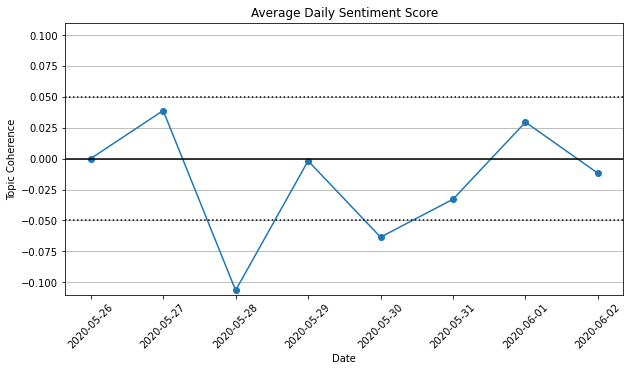

In [24]:
plt.figure(figsize=[10, 5])
plt.plot(sentiment_avg, marker='o')
plt.grid(axis = 'y')
plt.axhline(y = 0.05, color = 'black', linestyle = ':')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = -0.05, color = 'black', linestyle = ':')
plt.title("Average Daily Sentiment Score")
plt.xticks(rotation = 45)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Topic Coherence', fontsize = 10)
plt.ylim([-0.11, 0.11])

# LDA Section

# Finding best K

In [25]:
def topic_coherence(model, n_top_words, pair_score):
    coherences = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

## Positive Data-set

In [26]:
# the vectorizer object will be used to transform text to vector form
vectorizer_pos = CountVectorizer(max_df=0.95, min_df=2)

# apply transformation
tf_pos = vectorizer_pos.fit_transform(this_data_pos['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_pos_feature_names = vectorizer_pos.get_feature_names()

# check dimensions
print(tf_pos.shape)

(985, 921)


In [27]:
#Check: http://qpleple.com/topic-coherence-to-evaluate-topic-models/

In [28]:
Dwi = np.array(np.sum(tf_pos > 0, axis=0))[0]

W_bin = tf_pos
W_bin[W_bin > 0] = 1
Dwi_wj = W_bin.T @ W_bin

score_umass_pos = np.log((Dwi_wj.toarray() + 1)/ Dwi)

In [29]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
pos_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_pos = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_pos.fit(tf_pos)
    this_coh.append(np.median(topic_coherence(this_model_pos, 10, score_umass_pos)))
    pos_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
10.172838926315308 seconds


In [30]:
pos_topic_cohs

[[-6.091664665479309],
 [-6.945015251196566],
 [-68.39590542645604],
 [-10.789942517029047],
 [-64.6413032151993],
 [-110.79360609030245],
 [-102.88161994107237],
 [-36.01110234394042],
 [-48.99689580646246]]

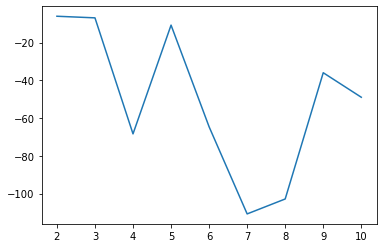

In [31]:
plt.plot(ks, pos_topic_cohs)

## Negative Data-set

In [32]:
# the vectorizer object will be used to transform text to vector form
vectorizer_neg = CountVectorizer(max_df=0.95, min_df=2) #, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf_neg = vectorizer_neg.fit_transform(this_data_neg['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_neg_feature_names = vectorizer_neg.get_feature_names()

# check dimensions
print(tf_neg.shape)

(1148, 1037)


In [33]:
Dwi_neg = np.array(np.sum(tf_neg > 0, axis=0))[0]

W_bin_neg = tf_neg
W_bin_neg[W_bin_neg > 0] = 1
Dwi_wj_neg = W_bin_neg.T @ W_bin_neg

score_umass_neg = np.log((Dwi_wj_neg.toarray() + 1)/ Dwi_neg)

In [34]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
neg_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_neg = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_neg.fit(tf_neg)
    this_coh.append(np.median(topic_coherence(this_model_neg, 10, score_umass_neg)))
    neg_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
11.431448221206665 seconds


In [35]:
neg_topic_cohs

[[-63.70841796486967],
 [-50.189416176551525],
 [-32.12802705695407],
 [-36.27520889002914],
 [-81.55290471632733],
 [-103.27104690534654],
 [-95.66626274870288],
 [-123.5781846488152],
 [-102.71430918671366]]

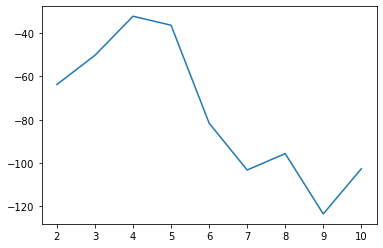

In [36]:
plt.plot(ks, neg_topic_cohs)

## Neutral Data-set

In [37]:
# the vectorizer object will be used to transform text to vector form
vectorizer_neu = CountVectorizer(max_df=0.95, min_df=2) #, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf_neu = vectorizer_neu.fit_transform(this_data_neu['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_neu_feature_names = vectorizer_neu.get_feature_names()

# check dimensions
print(tf_neu.shape)

(1297, 786)


In [38]:
Dwi_neu = np.array(np.sum(tf_neu > 0, axis=0))[0]

W_bin_neu = tf_neu
W_bin_neu[W_bin_neu > 0] = 1
Dwi_wj_neu = W_bin_neu.T @ W_bin_neu

score_umass_neu = np.log((Dwi_wj_neu.toarray() + 1)/ Dwi_neu)

In [39]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
neu_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_neu = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_neu.fit(tf_neu)
    this_coh.append(np.median(topic_coherence(this_model_neu, 10, score_umass_neu)))
    neu_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
12.805137157440186 seconds


In [40]:
neu_topic_cohs

[[-64.15778466317471],
 [-81.13728810359223],
 [-49.559777260088076],
 [-97.53630950323303],
 [-98.9609372719968],
 [-106.5498236322124],
 [-107.91151371159869],
 [-116.19229094228649],
 [-108.05534259389876]]

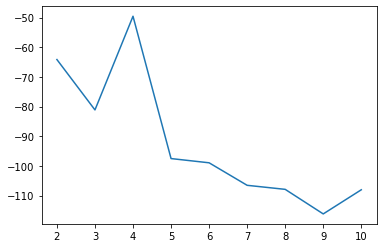

In [41]:
plt.plot(ks, neu_topic_cohs)

# Running on best k

Text(0, 0.5, 'Topic Coherence')

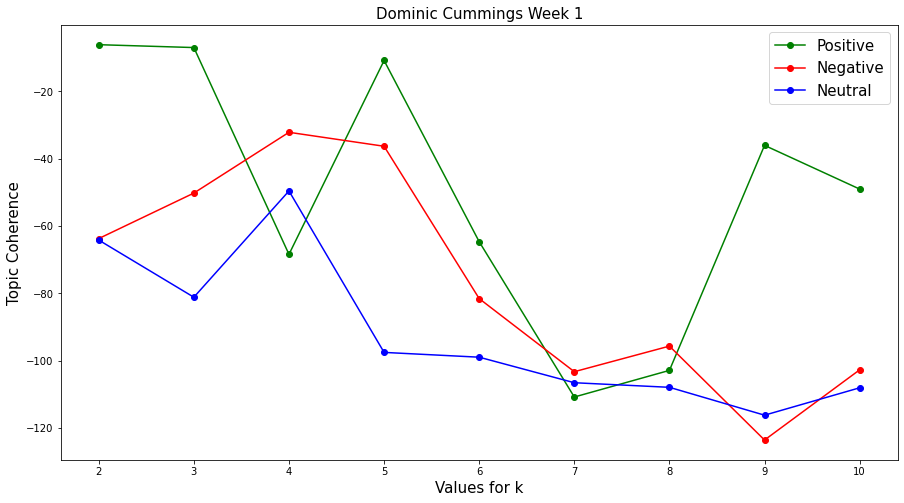

In [42]:
plt.figure(figsize=[15, 8])
plt.title("Dominic Cummings Week 1", fontsize = 15)
plt.plot(ks, pos_topic_cohs, label = 'Positive', marker='o', color = 'g')
plt.plot(ks, neg_topic_cohs, label = 'Negative', marker='o', color = 'r')
plt.plot(ks, neu_topic_cohs, label = 'Neutral', marker='o', color = 'b')
plt.legend(prop={"size":15})
plt.xlabel('Values for k', fontsize = 15)
plt.ylabel('Topic Coherence', fontsize = 15)


In [43]:
def plot_top_words(model, feature_names, n_top_words, title):
    """Function to plot topic models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Positive Data-Set

In [44]:
# Choose based on above results
number_of_topics = 3
n_top_words = 10

In [45]:
# model
model_pos = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_pos.fit(tf_pos)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

1.5297269821166992 seconds


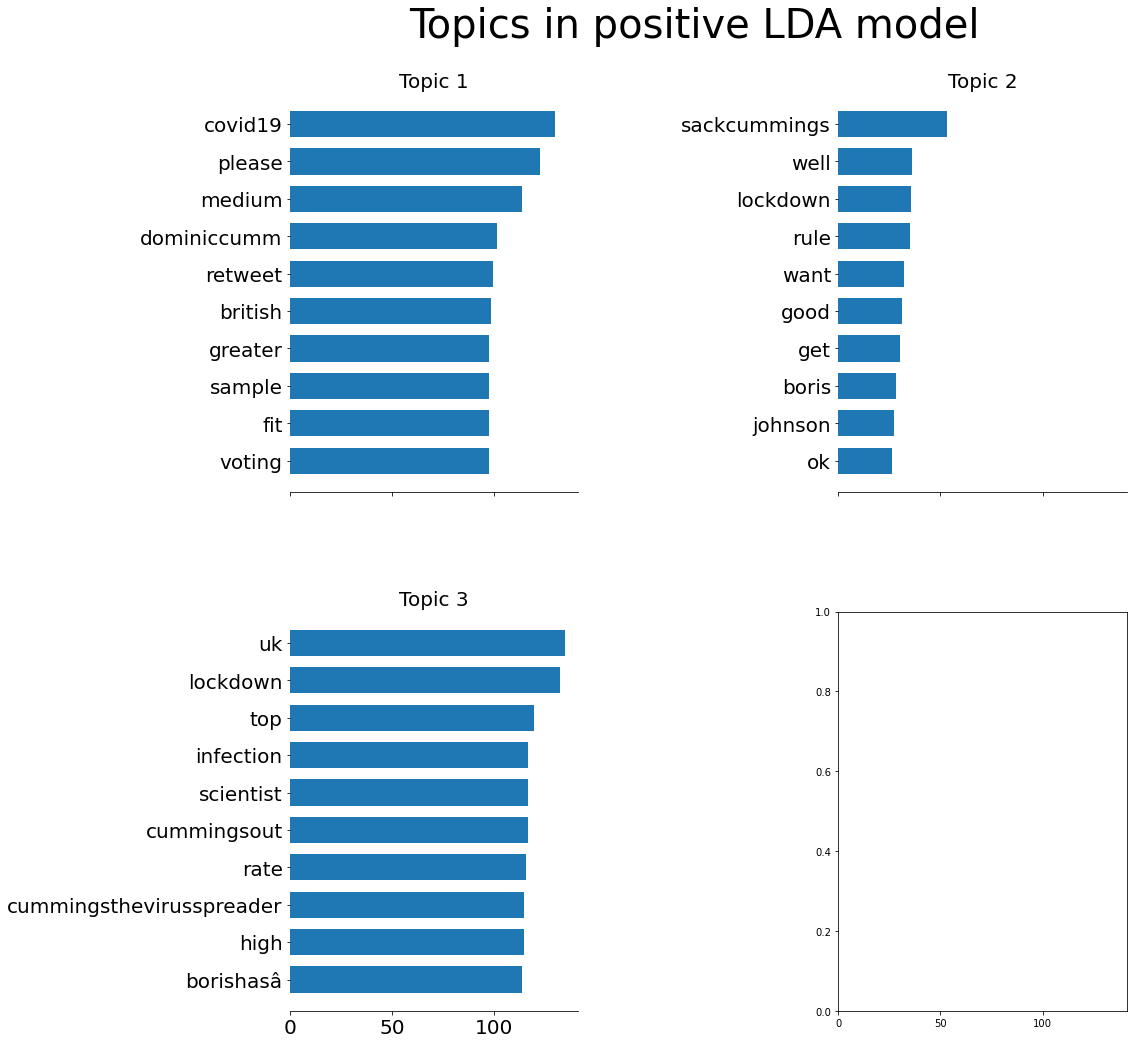

In [46]:
# Names of words 
plot_top_words(model_pos, tf_pos_feature_names, n_top_words, 'Topics in positive LDA model')

## Negative Data-Set

In [47]:
# Choose based on above results
number_of_topics = 4
n_top_words = 10

In [48]:
# model
model_neg = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_neg.fit(tf_neg)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

1.4919209480285645 seconds


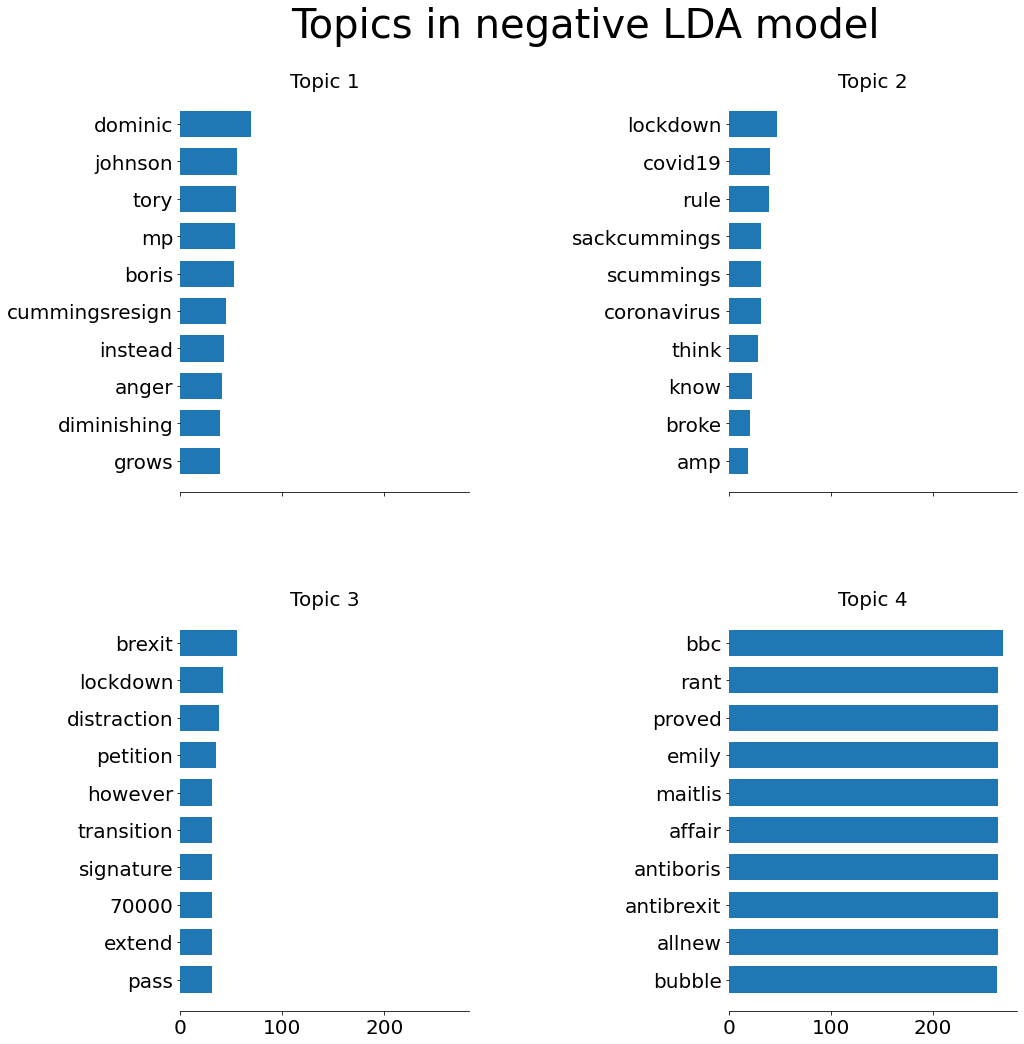

In [49]:
# Names of words 
plot_top_words(model_neg, tf_neg_feature_names, n_top_words, 'Topics in negative LDA model')

## Neutral Data-Set

In [50]:
# Choose based on above results
number_of_topics = 4
n_top_words = 10

In [51]:
# model
model_neu = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_neu.fit(tf_neu)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

1.4397470951080322 seconds


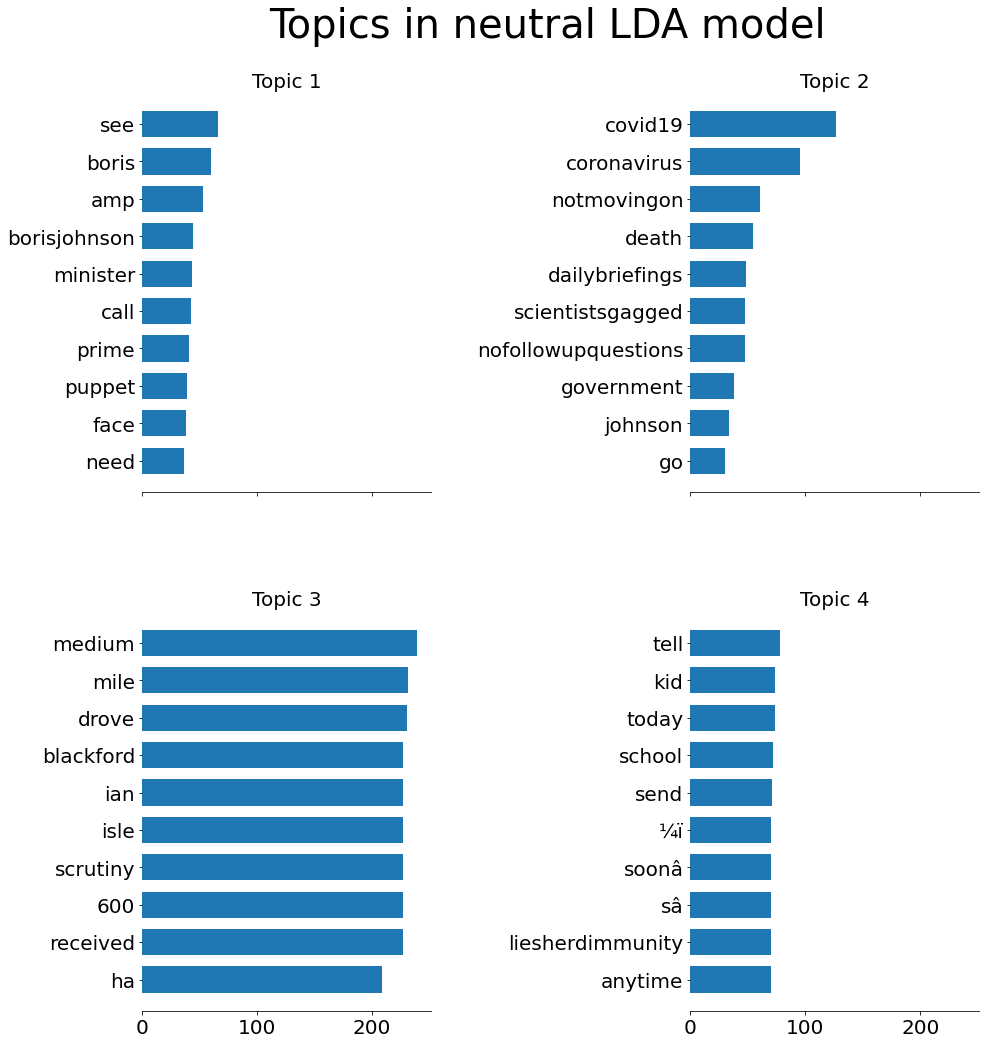

In [52]:
# Names of words 
plot_top_words(model_neu, tf_neu_feature_names, n_top_words, 'Topics in neutral LDA model')